In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("CreditScoring.csv")
data.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


#### Data Cleaning

In [3]:
data.columns = data.columns.str.lower()

In [4]:
data.isnull().sum()

status       0
seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

In [5]:
for column in ["status", "home", "marital", "records", "job"]:
    print(data[column].value_counts())

status
1    3200
2    1254
0       1
Name: count, dtype: int64
home
2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: count, dtype: int64
marital
2    3241
1     978
4     130
3      67
5      38
0       1
Name: count, dtype: int64
records
1    3682
2     773
Name: count, dtype: int64
job
1    2806
3    1024
2     452
4     171
0       2
Name: count, dtype: int64


In [6]:
values = {
    "status": {
        1: 'ok',
        2: 'default',
        0: 'unknown'
    },
    "home": {
        1: "rent",
        2: "owner",
        3: "priv",
        4: "ignore",
        5: "parents",
        6: "other",
        0: "unknown"
    },
    "marital": {
        1: "single",
        2: "married",
        3: "widow",
        4: "separated",
        5: "divorced",
        0: "unknown"
    },
    "records": {
        1: "no",
        2: "yes",
        0: "unknown"
    },
    "job": {
        1: "fixed",
        2: "partime",
        3: "freelance",
        4: "others",
        0: "unknown"
    }
}

In [7]:
for key, value in values.items():
    data[key] = data[key].map(value)

In [8]:
data.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658


In [9]:
data.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
# 99999999.0 are zeros and we will replace them with nan
import numpy as np
for col in ["income", "assets", "debt"]:
    data[col] = data[col].replace(99999999.0, np.nan)

In [11]:
data = data[data['status'] != 'unknown'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(data, test_size=0.25, random_state=11)

In [13]:
# df_train = df_train.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)

# y_train = df_train.pop('status')
# y_test = df_test.pop('status')
# y_val = df_val.pop('status')

# y_train = (y_train == 'default').astype('int').values
# y_test = (y_test == 'default').astype('int').values
# y_val = (y_val == 'default').astype('int').values

In [14]:
dfs = [df_train, df_test, df_val]
ys = []

for df in dfs:
    df.reset_index(drop=True)
    y = df.pop('status')
    y = (y == 'default').astype('int').values
    ys.append(y)

y_train, y_test, y_val = ys

In [15]:
df_train.shape, df_val.shape, df_test.shape

((3340, 13), (1114, 13), (891, 13))

#### Decision trees

In [16]:
df_train.iloc[0].to_dict()

{'seniority': 1,
 'home': 'rent',
 'time': 36,
 'age': 24,
 'marital': 'married',
 'records': 'no',
 'job': 'partime',
 'expenses': 41,
 'income': 56.0,
 'assets': 0.0,
 'debt': 0.0,
 'amount': 500,
 'price': 585}

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier

In [18]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [20]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
y_val_pred = dt.predict(X_val)

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val_pred, y_val)

0.6502842183994015

In [23]:
from sklearn.metrics import roc_auc_score
y_train_pred = dt.predict(X_train)
roc_auc_score(y_train, y_train_pred)

1.0

In [24]:
# This is a case of overfitting due to the depth of the tree
# Let's train another tree with smaller depth

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [25]:
y_train_pred = dt.predict_proba(X_train)[:, 1]
auc_train_score = roc_auc_score(y_train, y_train_pred)

y_val_pred = dt.predict_proba(X_val)[:, 1]
auc_val_score = roc_auc_score(y_val, y_val_pred)

display(auc_train_score, auc_val_score)

0.6972613817060012

0.6624278637454675

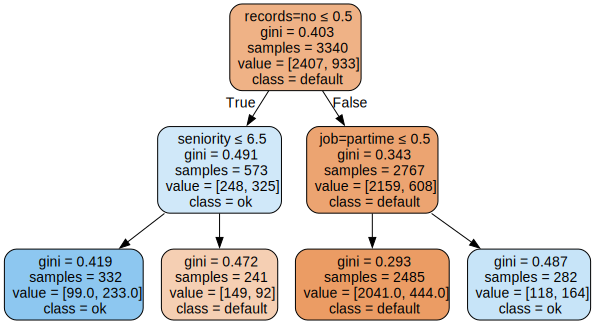

In [28]:
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from IPython.display import Image
import graphviz


dot_data = export_graphviz(dt, out_file=None, feature_names=dv.get_feature_names_out(), class_names=['default', 'ok'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree") # Save as file graph
graph

In [27]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



#### Decision Tree Learning Algorithm

* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [46]:
data = [
    [8000, "default"],
    [2000, "default"],
    [0, "default"],
    [5000, "ok"],
    [5000, "ok"],
    [4000, "ok"],
    [9000, "ok"],
    [3000, "default"],
]
df_example = pd.DataFrame(data, columns=["amount", "status"])

In [47]:
df_example.sort_values("amount")

,amount,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [44]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

for T in Ts:
    df_left = df_example[df_example.amount <= T]
    df_right = df_example[df_example.amount > T]

    print(f"left hand side of {T} \n{df_left.status.value_counts(normalize=True)}")
    display(df_left)
    print(f"right hand side of {T} \n{df_right.status.value_counts(normalize=True)}")
    display(df_right)

    print()

left hand side of 0 
status
default    1.0
Name: proportion, dtype: float64


,amount,status
2,0,default


right hand side of 0 
status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,amount,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default



left hand side of 2000 
status
default    1.0
Name: proportion, dtype: float64


,amount,status
1,2000,default
2,0,default


right hand side of 2000 
status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,amount,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default



left hand side of 3000 
status
default    1.0
Name: proportion, dtype: float64


,amount,status
1,2000,default
2,0,default
7,3000,default


right hand side of 3000 
status
ok         0.8
default    0.2
Name: proportion, dtype: float64


,amount,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok



left hand side of 4000 
status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,amount,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


right hand side of 4000 
status
ok         0.75
default    0.25
Name: proportion, dtype: float64


,amount,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok



left hand side of 5000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


right hand side of 5000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,status
0,8000,default
6,9000,ok



left hand side of 8000 
status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,amount,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


right hand side of 8000 
status
ok    1.0
Name: proportion, dtype: float64


,amount,status
6,9000,ok


In [65]:
data = [
    [8000, 3000, "default"],
    [2000, 1000, "default"],
    [0, 1000, "default"],
    [5000, 1000, "ok"],
    [5000, 1000, "ok"],
    [4000, 1000, "ok"],
    [9000, 500, "ok"],
    [3000, 2000, "default"],
]
df_example1 = pd.DataFrame(data, columns=["amount", "debt", "status"])

In [66]:
df_example1.sort_values('debt')

,amount,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [67]:
thresholds = {
    'amount': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [68]:
for feature, Ts in thresholds.items():
    print("#######")
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example1[df_example1[key] <= T]
        df_right = df_example1[df_example1[key] > T]
    
        print(f"left hand side of {T} \n{df_left.status.value_counts(normalize=True)}")
        display(df_left)
        print(f"right hand side of {T} \n{df_right.status.value_counts(normalize=True)}")
        display(df_right)
    
        print() 

#######
amount
0
left hand side of 0 
Series([], Name: proportion, dtype: float64)


,amount,debt,status


right hand side of 0 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default



2000
left hand side of 2000 
status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


right hand side of 2000 
status
default    1.0
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default



3000
left hand side of 3000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


right hand side of 3000 
Series([], Name: proportion, dtype: float64)


,amount,debt,status



4000
left hand side of 4000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


right hand side of 4000 
Series([], Name: proportion, dtype: float64)


,amount,debt,status



5000
left hand side of 5000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


right hand side of 5000 
Series([], Name: proportion, dtype: float64)


,amount,debt,status



8000
left hand side of 8000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


right hand side of 8000 
Series([], Name: proportion, dtype: float64)


,amount,debt,status



#######
debt
500
left hand side of 500 
status
ok    1.0
Name: proportion, dtype: float64


,amount,debt,status
6,9000,500,ok


right hand side of 500 
status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default



1000
left hand side of 1000 
status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


right hand side of 1000 
status
default    1.0
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
7,3000,2000,default



2000
left hand side of 2000 
status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


right hand side of 2000 
status
default    1.0
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default


##### Stopping criteria to stop splitting the tree

* Group already pure (0% impurity)
* Tree reached depth limit
* Group too small to split

##### Decision Tree Learning Algorithm

* Find the best split
* Stop if Max_depth is reached
* If left is sufficiently large and not pure
    * Repeat for left
* If right is sufficiently large and not pure
    * Repeat for right

#### Decision Trees Parameter Tuning